# Analyzing Hugging Face Posts with Graphs and Agents

[txtai](https://github.com/neuml/txtai) is an all-in-one embeddings database for semantic search, LLM orchestration and language model workflows.

Embeddings databases can optionally build a graph network alongside stored vectors. The graph automatically infers relationships of the content using the computed vector embeddings. This provides an additional way to explore and analyze content. 

txtai 8.0 was recently released and added the ability to run agents. Agents automatically create workflows to answer multi-faceted user requests.

This notebook will demonstrate how to use these concepts with the [Hugging Face Posts dataset](https://huggingface.co/datasets/maxiw/hf-posts). If you're not familar with semantic graphs, graph traversal and agents in txtai, then check out the articles below before continuing on. 

Articles to review:
  - [Introducing the Semantic Graph](https://neuml.hashnode.dev/introducing-the-semantic-graph)
  - [Advanced RAG with graph path traversal](https://neuml.hashnode.dev/advanced-rag-with-graph-path-traversal)
  - [What's new in txtai 8.0](https://neuml.hashnode.dev/whats-new-in-txtai-80)

# Install dependencies

Install `txtai` and all dependencies.

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[agent,graph] datasets autoawq

# Hugging Face Posts

[Hugging Face Posts](https://huggingface.co/posts) is a microblog site. It has over 2,000 unique posts as of November 2024. The next section defines methods to yield records from this dataset.

Additionally, it loads an LLM to infer titles for each post.

In [ ]:
from datasets import load_dataset
from txtai import LLM

llm = LLM("hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4")

def title(text):
    prompt = f"""
Create a simple, concise topic for the following text. Only return the topic name.

Text:
{text}
"""

    return llm([{"role": "user", "content": prompt}], maxlength=2048)

def hfposts():
    ds = load_dataset("maxiw/hf-posts", split="train")
    for row in ds:
        yield {
            "id": title(row["rawContent"]),
            "text": row["rawContent"],
            "author": row["author"]["name"],
            "date": row["publishedAt"],
            "url": f"https://hf.co{row['url']}",
            "reactions": sum(x["count"] for x in row["reactions"]),
            "views": row["totalUniqueImpressions"],
            "comments": row["numComments"]
        }


Now, let's build an Embeddings index. We'll store vectors, content and build a graph network. The graph network automatically builds relationships between the records using vector similarity.

In [ ]:
from tqdm import tqdm
from txtai import Embeddings

embeddings = Embeddings(
    autoid="uuid5",
    path="intfloat/e5-large",
    instructions={"query": "query: ", "data": "passage: "},
    content=True,
    graph={"approximate": False, "minscore": 0.7},
)
embeddings.index(tqdm(hfposts()))

With a modern GPU, this step shouldn't take long. The longest part of the process is running 2000+ LLM prompts to generate titles. Without that, it would only take a few seconds to build the embeddings index.

If you'd like to skip this step, you can instead load a pre-computed embeddings index from the Hugging Face Hub as follows.

```python
embeddings = Embeddings()
embeddings.load(provider="huggingface-hub", container="neuml/txtai-hfposts")
```

Let's run a sample search to verify the index is working.

In [135]:
embeddings.search("transformers")

[{'id': 'AI Music Generation',
  'text': 'Love this new Space built by @enzostvs + @Xenova for Transformers.js: Generate your own AI music (In-browser generation) with AI Jukebox \n\nhttps://huggingface.co/spaces/enzostvs/ai-jukebox',
  'score': 0.8460421562194824},
 {'id': 'Kolmogorov Arnold Networks',
  'text': 'Transformers are not all we need, that is being proven repeatedly now as more alternative frameworks emerge. Another such framework is Kolmogorov Arnold Network based Transformers. I break down exactly how these differ from Perceptron based Transformers and give you the link to my Colab where I create a model based on the research paper that absolutely destroys a standard Transformers based model. Check out the video here: https://www.youtube.com/watch?v=Sw0euxNZCc4',
  'score': 0.8424240350723267},
 {'id': 'GitHub Issue 8771',
  'text': 'This issue is just a treasure ! A bit deprecated i guess, but things are in their historical context. (personally, still need more to under

Looks good!

# Graph Analysis

Next up, graphs! We'll define methods to plot our graphs and subgraphs.

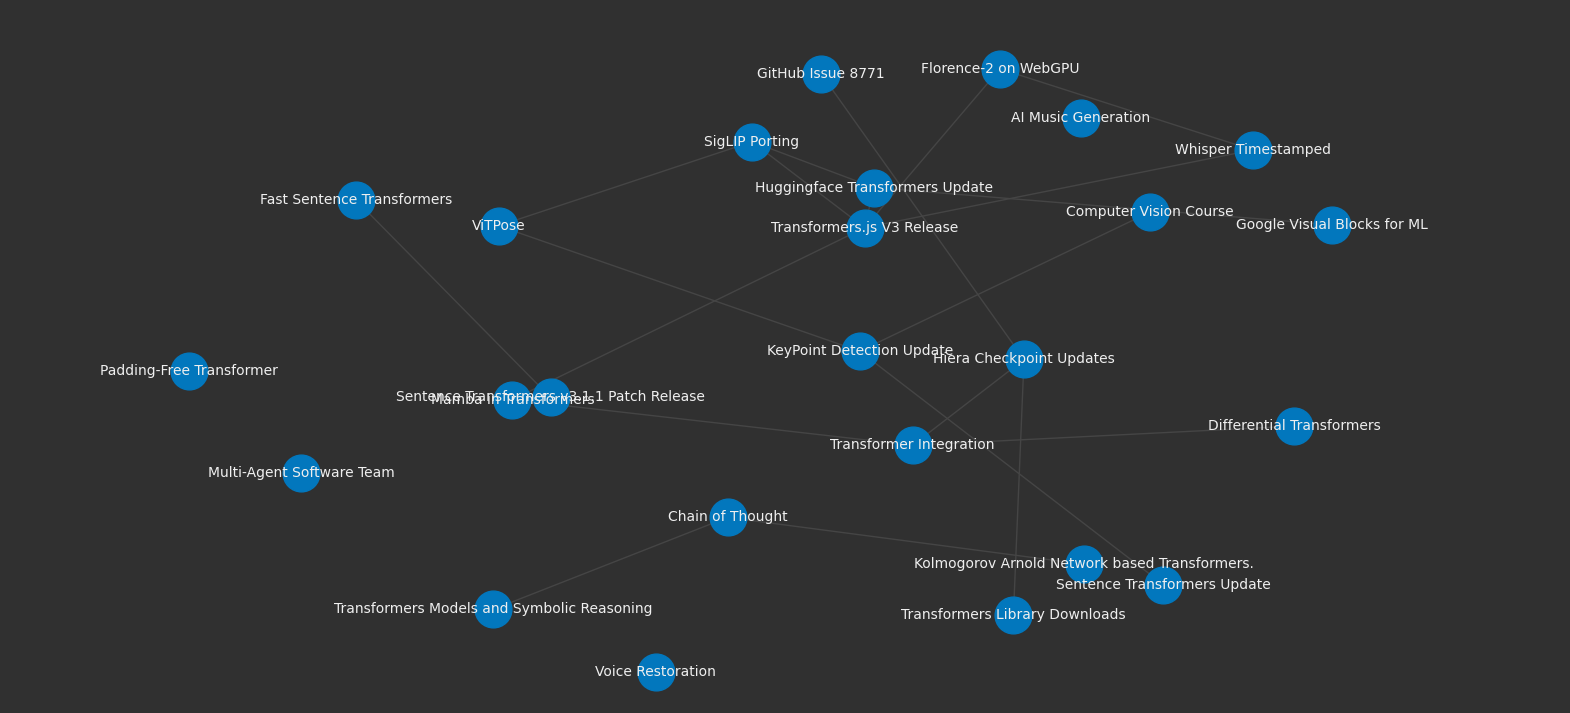

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

def plot(graph):
    labels = {x: f"{graph.attribute(x, 'id')}" for x in graph.scan()}

    options = {
        "node_size": 700,
        "node_color": "#0277bd",
        "edge_color": "#454545",
        "font_color": "#efefef",
        "font_size": 10,
        "alpha": 1.0,
    }

    # Draw graph
    fig, ax = plt.subplots(figsize=(20, 9))
    pos = nx.spring_layout(graph.backend, seed=0, k=0.9, iterations=50)
    nx.draw_networkx(graph.backend, pos=pos, labels=labels, **options)

    # Disable axes and draw margins
    ax.axis("off")
    plt.margins(x=0.15)

    # Set background color
    ax.set_facecolor("#303030")
    fig.set_facecolor("#303030")

    plt.show()

def authorplot(author, limit):
    count = embeddings.search("SELECT count(*) count FROM txtai WHERE author=:author", 1, parameters={"author": author})[0]["count"]
    print(f"Total posts for `{author}` = {count}. Using up to {limit} posts for graph.")

    plot(embeddings.search(
        "SELECT id, text, score FROM txtai WHERE author=:author ORDER BY views desc",
        limit, parameters={"author": author}, graph=True
    ))

plot(embeddings.search("transformers", 25, graph=True))

Everything looks good! The graph above shows a network of posts related to `transformers`.

# Plot by Author

Let's take a look at a couple authors. First up, the CEO of Hugging Face, [Clem Delangue](https://huggingface.co/clem).

Below is a graph of his 20 most popular posts. Any themes emerge?

Total posts for `clem` = 29. Using up to 20 posts for graph.


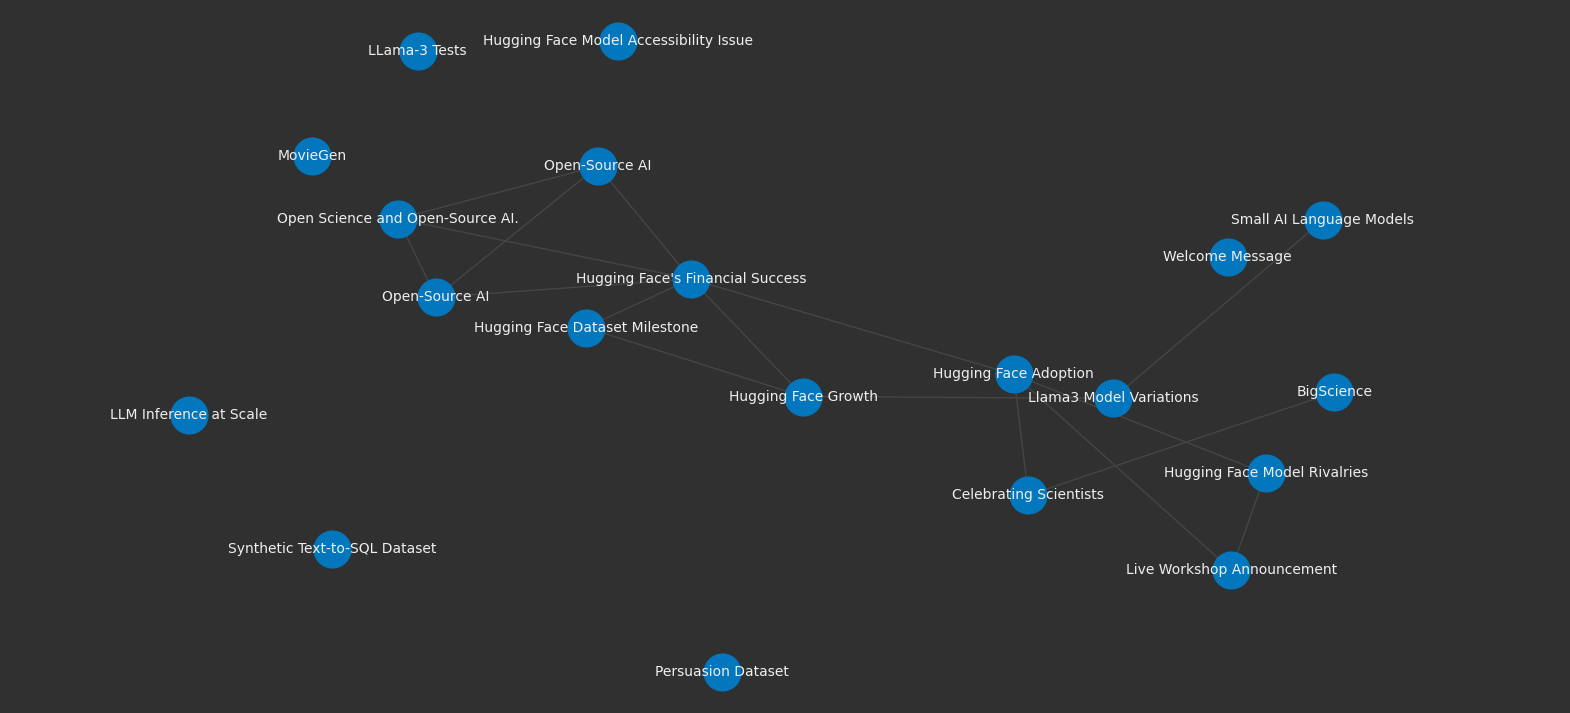

In [4]:
authorplot("clem", 20)

Next, let's see what [Tom Aarsen](https://huggingface.co/tomaarsen), the primary developer of [Sentence Transformers](https://github.com/UKPLab/sentence-transformers), talks about.

_p.s. It's not surprising._

Total posts for `tomaarsen` = 14. Using up to 5 posts for graph.


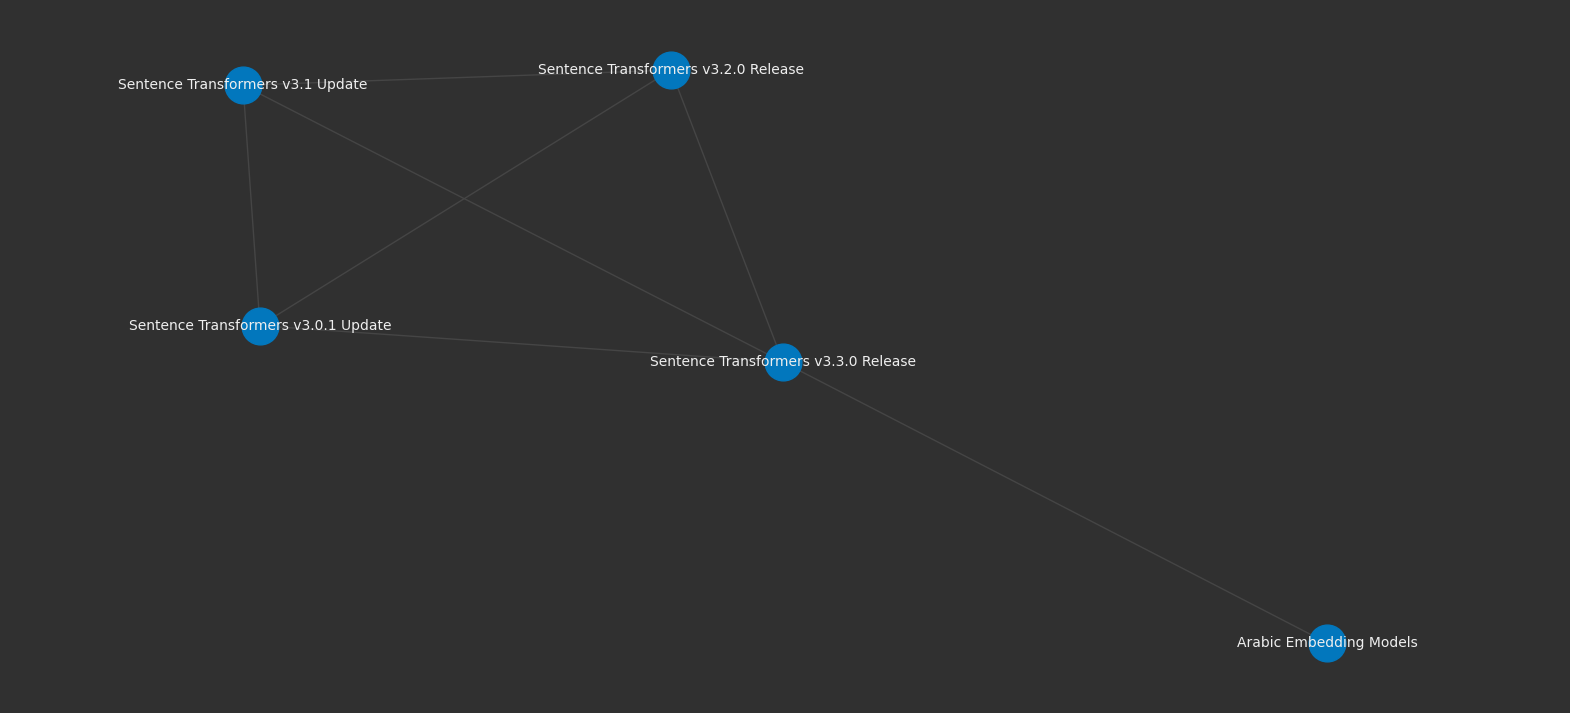

In [77]:
authorplot("tomaarsen", 5)

# Top authors by reactions

Now, let's take a look at the Top 3 authors with the most reactions and see what they're talking about.

Total posts for `merve` = 72. Using up to 20 posts for graph.


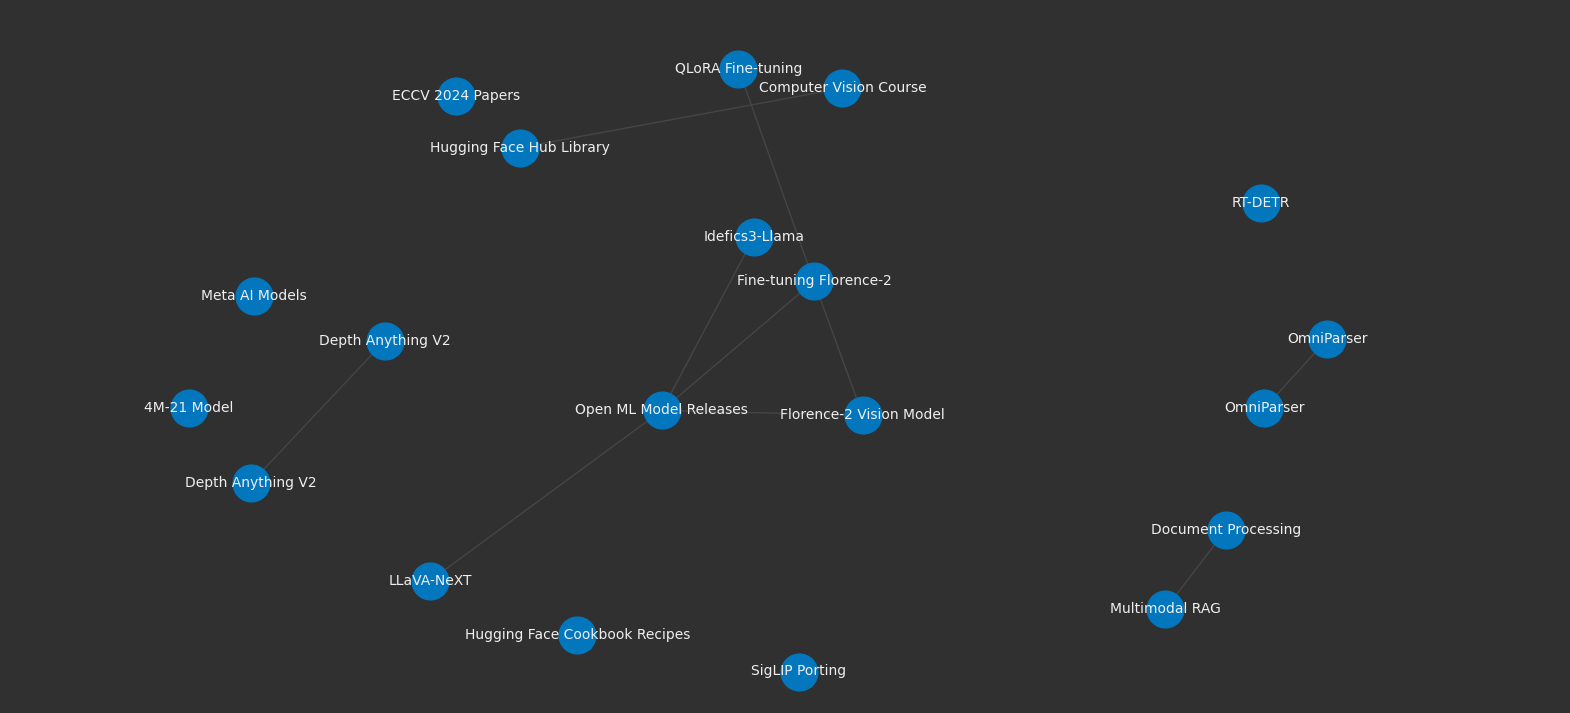

Total posts for `akhaliq` = 80. Using up to 20 posts for graph.


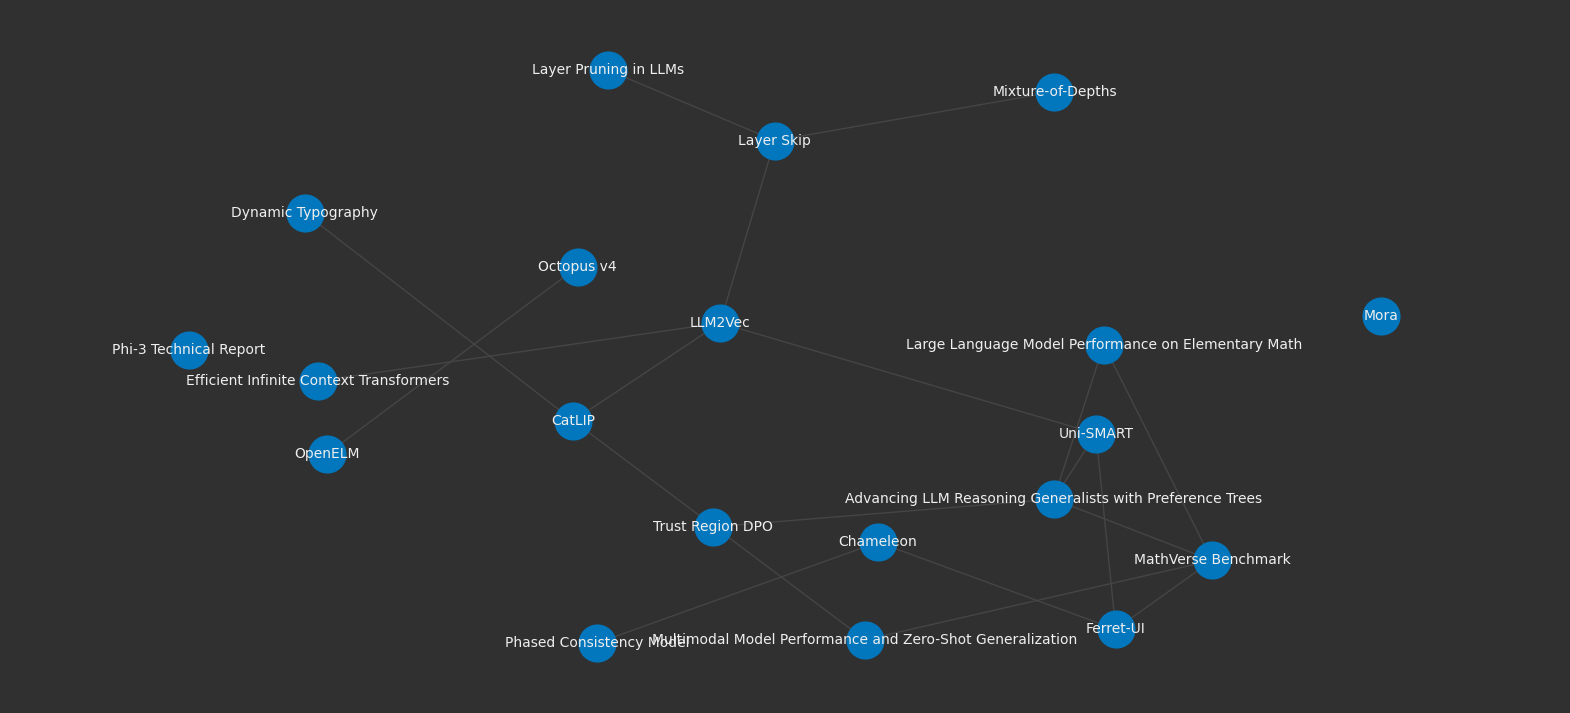

Total posts for `MonsterMMORPG` = 46. Using up to 20 posts for graph.


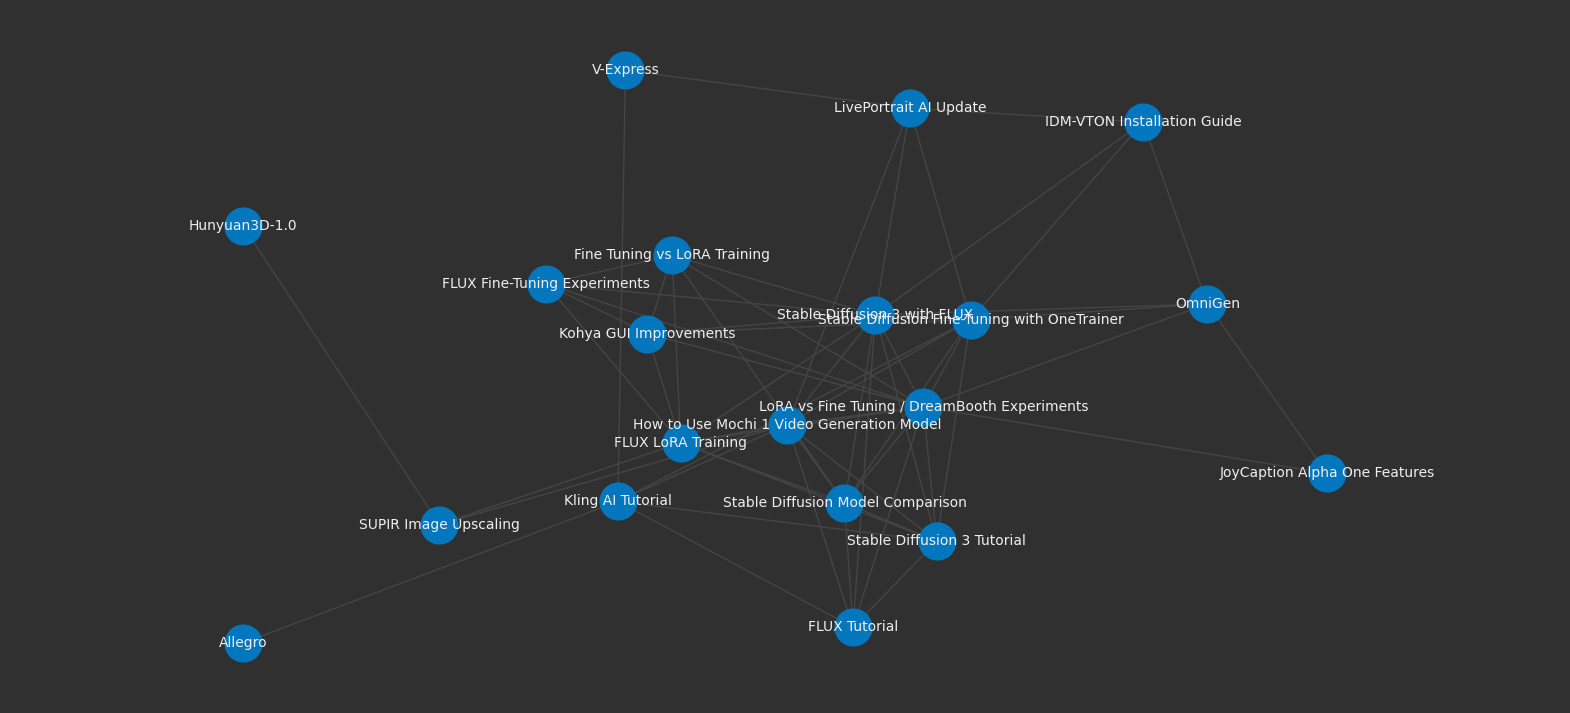

In [81]:
for row in embeddings.search("SELECT SUM(reactions), author FROM txtai GROUP BY author ORDER BY SUM(reactions) desc", 3):
    authorplot(row["author"], 20)

🔥 Quite interesting! Perhaps some pointers on topics to write articles and posts about?

# Top posts by reactions

Now, we'll plot the Top 25 most reacted to posts.

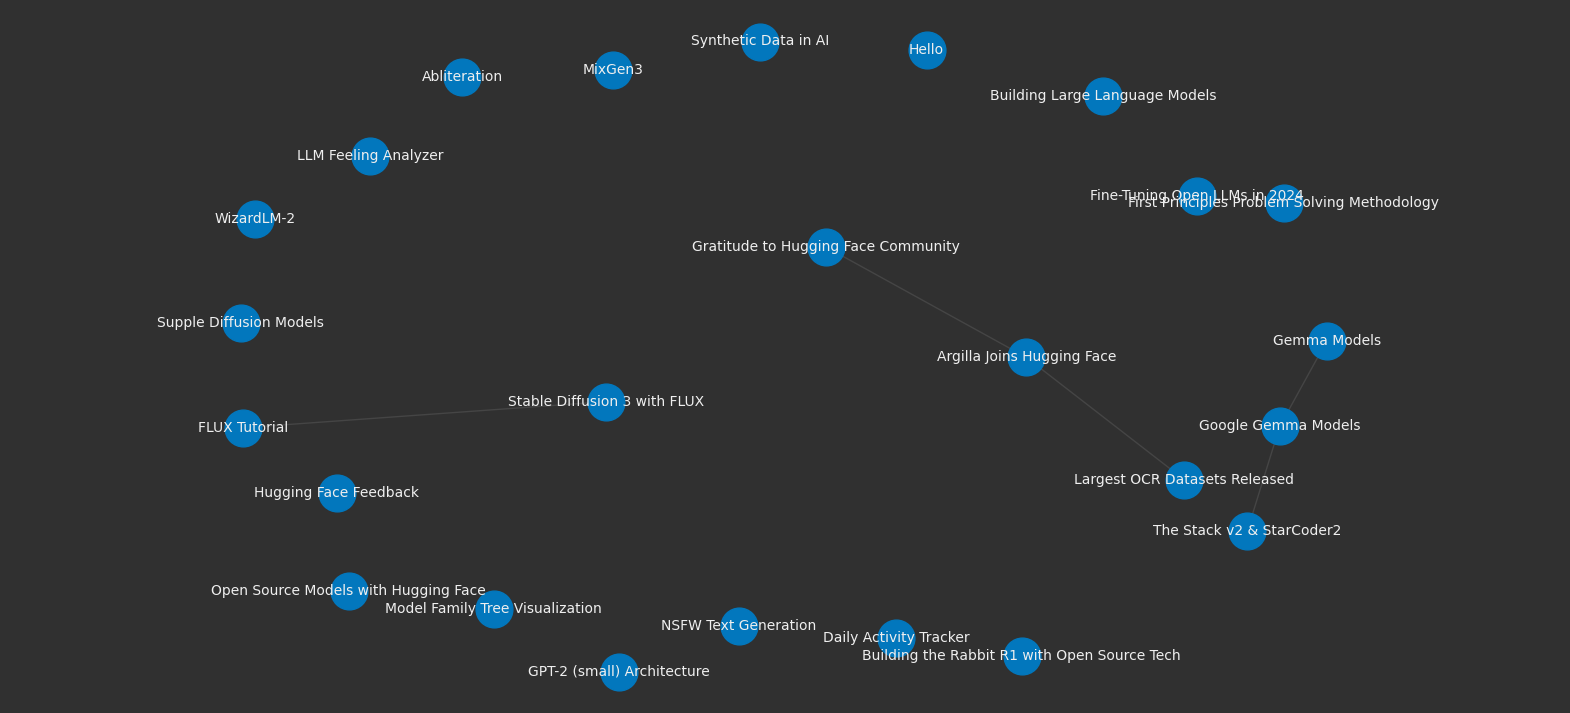

In [7]:
plot(embeddings.search("SELECT id, text, score FROM txtai ORDER BY reactions desc", 25, graph=True))

Let's look at a post to show how it looks.

In [9]:
embeddings.search("SELECT id, text, author, url, date, reactions, views, comments FROM txtai WHERE id='Building Large Language Models'")

[{'id': 'Building Large Language Models',
  'text': "A Little guide to building Large Language Models in 2024\n\nThis is a post-recording of a 75min lecture I gave two weeks ago on how to train a LLM from scratch in 2024. I tried to keep it short and comprehensive – focusing on concepts that are crucial for training good LLM but often hidden in tech reports.\n\nIn the lecture, I introduce the students to all the important concepts/tools/techniques for training good performance LLM:\n* finding, preparing and evaluating web scale data\n* understanding model parallelism and efficient training\n* fine-tuning/aligning models\n* fast inference\n\nThere is of course many things and details missing and that I should have added to it, don't hesitate to tell me you're most frustrating omission and I'll add it in a future part. In particular I think I'll add more focus on how to filter topics well and extensively and maybe more practical anecdotes and details.\n\nNow that I recorded it I've been 

# Graph traversal

As we've now seen, embeddings indexes that have an associated graph network have relationships!

These relationships can also be utilized to explore the dataset. The query below walks relationships between the `Argilla Joins Hugging Face` and `Hugging Face Growth` nodes and plots the graph.

The search syntax below uses openCypher. Learn more about this in [txtai's documentation](https://neuml.github.io/txtai/embeddings/query/#graph-search).

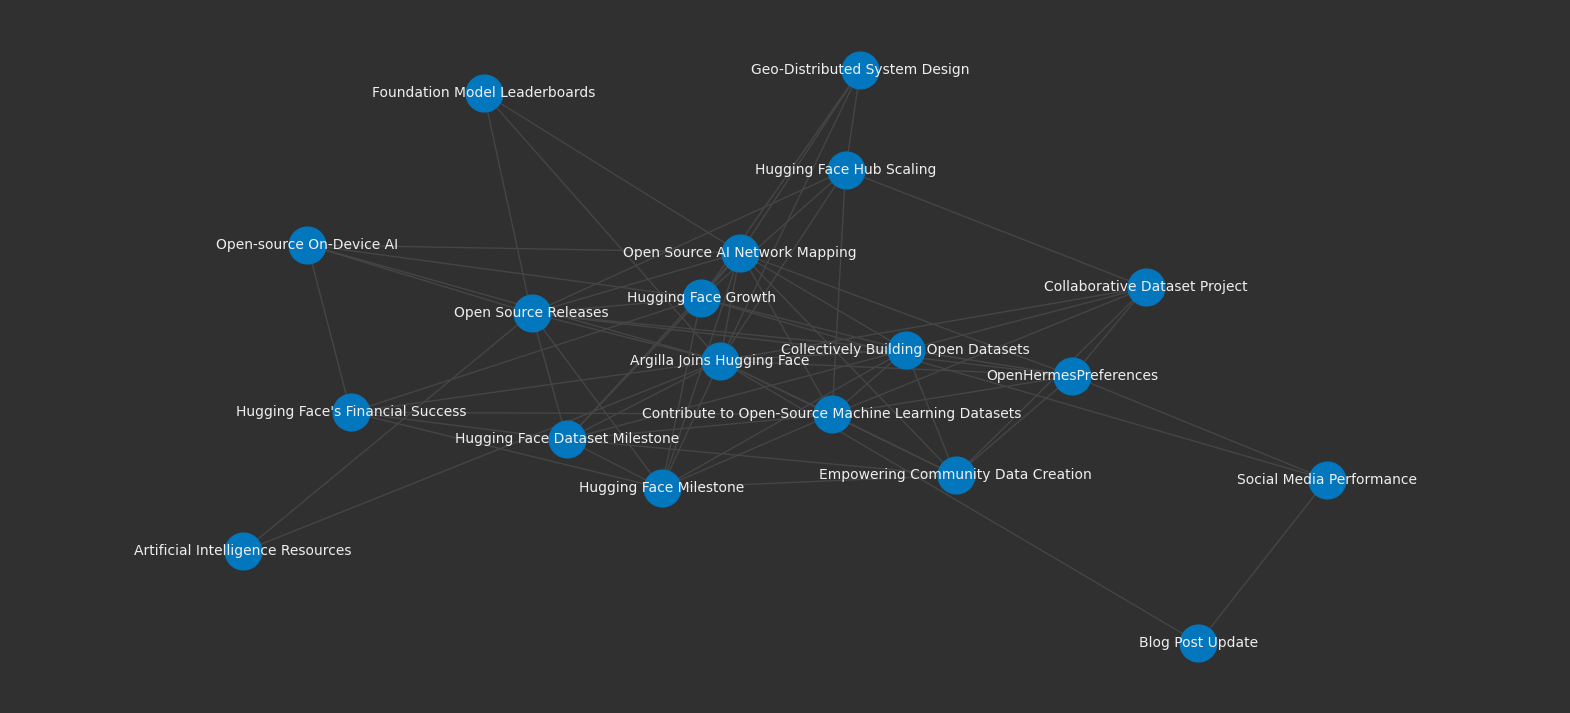

In [73]:
g = embeddings.graph.search("""
MATCH P=({id: "Argilla Joins Hugging Face"})-[*1..3]->({id: "Hugging Face Growth"})
RETURN P
LIMIT 30
""", graph=True)

plot(g)

# Agents

By now, we should get the idea on graphs! Time to move on to agents. Agents automatically create workflows to answer multi-faceted user requests. Agents iteratively prompt and/or interface with tools to step through a process and ultimately come to an answer for a request.

Let's connect our database to an agent.

In [10]:
from txtai import Agent

posts = {
    "name": "posts",
    "description": "Searches a database of technical blog posts",
    "target": embeddings
}

agent = Agent(
    tools=[posts],
    llm=llm,
    max_iterations=10,
)

In [ ]:
from IPython.display import display, Markdown

def md(output):
    display(Markdown(output))

researcher = """
You're looking to learn more about {topic}. Do the following.
 - Search for posts related to the topic.
 - Write a report with references hyperlinks.
 - Write the text as Markdown.
"""

md(agent(researcher.format(topic="hugging face and open source AI")))

======== New task ========

You're looking to learn more about hugging face and open source AI. Do the following.
 - Search for posts related to the topic.
 - Write a report with references hyperlinks.
 - Write the text as Markdown.

=== Agent thoughts:
Thought: I will start by searching for posts related to the topic of Hugging Face and Open Source AI.
>>> Calling tool: 'posts' with arguments: {'query': 'Hugging Face Open Source AI'}
=== Agent thoughts:
Thought: Now that I have the search results, I can write a report with references and hyperlinks.
>>> Calling tool: 'final_answer' with arguments: {'answer': "### Hugging Face and Open Source AI\n\nHugging Face is a leading player in the open source AI ecosystem. Their commitment to democratizing AI has led to significant growth in the community, with over 1 million public models available on their platform.\n\n#### Key Developments\n\n*   **Hugging Face's AI Initiative**: The company has committed $10 million in free GPUs to help deve

### Hugging Face and Open Source AI

Hugging Face is a leading player in the open source AI ecosystem. Their commitment to democratizing AI has led to significant growth in the community, with over 1 million public models available on their platform.

#### Key Developments

*   **Hugging Face's AI Initiative**: The company has committed $10 million in free GPUs to help developers create new AI technologies, promoting collaboration and transparency in the AI community.

*   **Open Source Models with Hugging Face**: Hugging Face has been instrumental in making hundreds of thousands of already-trained open source models available for developers to assemble into new applications.

*   **Hugging Face Competitions**: The company has launched an open-source platform for creating machine learning competitions, allowing developers to create and host competitions for free.

#### References

*   [Huggingface AI Ecosystem](https://huyenchip.com/2024/03/14/ai-oss.html)
*   [Hugging Face's AI Initiative](https://www.theverge.com/2024/5/16/24156755/hugging-face-celement-delangue-free-shared-gpus-ai)
*   [Open Source Models with Hugging Face](https://www.deeplearning.ai/short-courses/open-source-models-hugging-face/)
*   [Hugging Face Competitions](https://github.com/huggingface/competitions)
*   [Hugging Face Milestone](https://huggingface.co/spaces/cfahlgren1/hub-stats)

There is a lot to unpack here. The agent has access to the Embeddings database as a tool. The prompt asks the agent to research a specific topic, `hugging face and open source AI` and build a report. We can see the series of steps this undertook and the report output (with links pulled out from the posts!). 

Very cool 😎

Next we'll make a slight change to our agent. We'll give it a custom function instead of an embeddings database. This function still runs a search but in a more specific way, by author.

In [56]:
def search(author):
    """
    Searches a database of blog posts by author.

    Args:
        author: lower case author id to search for
 
    Returns:
        list of blog post texts for author
    """

    return embeddings.search("SELECT text FROM txtai WHERE author=:author ORDER BY views desc", 20, parameters={"author": author})

agent = Agent(
    tools=[search],
    llm=llm,
    max_iterations=5,
)

In [ ]:
md(agent("Summarize what clem talks about as a list of 5 items in Markdown format", maxlength=16000))

======== New task ========
Summarize what clem talks about as a list of 5 items in Markdown format
=== Agent thoughts:
Thought: I will first search the database of blog posts by Clem to find what he talks about, then I will summarize the results as a list of 5 items in Markdown format.
>>> Calling tool: 'search' with arguments: {'author': 'clem'}
=== Agent thoughts:
Thought: I will now summarize the results as a list of 5 items in Markdown format.
>>> Calling tool: 'final_answer' with arguments: {'answer': "- **5,000 new repos are created every day on Hugging Face**: The community is amazing and contributing to the growth of open-source AI.\n- **Hugging Face is profitable**: With 220 team members and most of their platform being free and open-source for the community.\n- **Clem is excited about Hugging Face's success**: He mentions that they have plenty of money in the bank and are profitable.\n- **Clem is hosting a live workshop**: With team members next week about the Enterprise Hugg

- **5,000 new repos are created every day on Hugging Face**: The community is amazing and contributing to the growth of open-source AI.
- **Hugging Face is profitable**: With 220 team members and most of their platform being free and open-source for the community.
- **Clem is excited about Hugging Face's success**: He mentions that they have plenty of money in the bank and are profitable.
- **Clem is hosting a live workshop**: With team members next week about the Enterprise Hugging Face hub, and 1,000 spots are available.
- **Clem is advocating for open-source AI**: He believes that it creates healthy competition and pushes companies to build AI faster, attract the best scientists and engineers, and generate more visibility and community contributions.

Even though we've seen LLM outputs a bazillion times by now, it's still amazing to see how good of a job it can do, under the right circumstances.

Let's show the previous graph again. Sounds about right?

Total posts for `clem` = 29. Using up to 20 posts for graph.


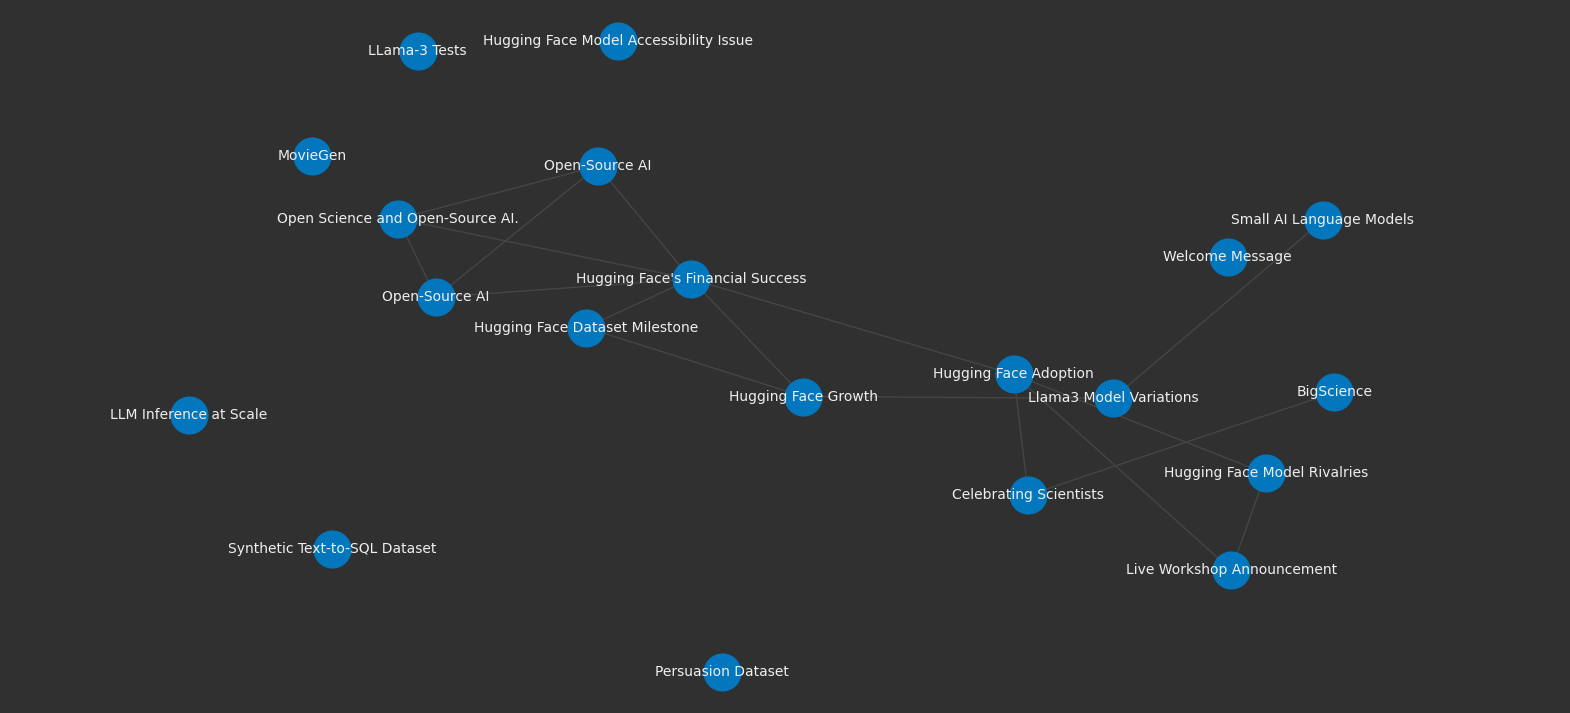

In [58]:
authorplot("clem", 20)

Last but certainly not least, we'll do the same thing for Tom Aarsen.

In [ ]:
md(agent("Summarize what tomaarsen talks about", maxlength=20000))

======== New task ========
Summarize what tomaarsen talks about
=== Agent thoughts:
Thought: I will use the tool'search' to find information about tomaarsen and then summarize what I found.
>>> Calling tool: 'search' with arguments: {'author': 'tomaarsen'}
=== Agent thoughts:
Thought: I will summarize the content by tomaarsen.
>>> Calling tool: 'search' with arguments: {'author': 'tomaarsen'}
=== Agent thoughts:
Thought: I will summarize the content by tomaarsen.
The content is about updates to the Sentence Transformers library, including new features and improvements.
>>> Calling tool: 'final_answer' with arguments: The content is about updates to the Sentence Transformers library, including new features and improvements.


The content is about updates to the Sentence Transformers library, including new features and improvements.

Total posts for `tomaarsen` = 14. Using up to 5 posts for graph.


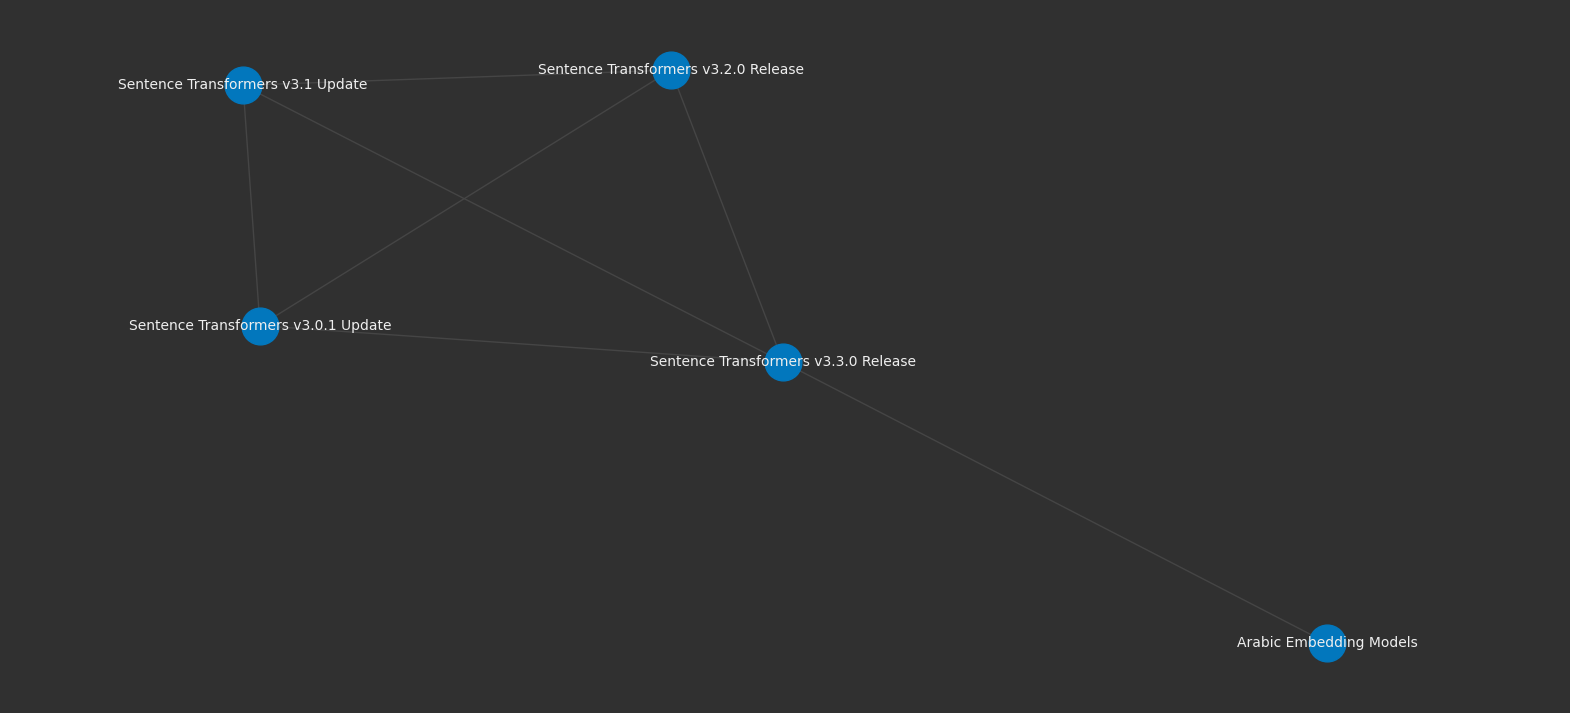

In [64]:
authorplot("tomaarsen", 5)

# Wrapping up

This notebook demonstrated how to use graphs and agents to explore the [Hugging Face Posts dataset](https://huggingface.co/datasets/maxiw/hf-posts). It was very illuminating. 💡

We hope you had as much fun as we did!